# Part 0: Set up
Import packages

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from datetime import datetime


# Set the style & colors for the plots
sns.set_style('darkgrid')
_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

---
# Part 1: Generate data

- Continuous data
- Normal distributed

In [82]:
np.random.seed(5)
true_mean_C, true_sigma_C = 20, 3 # Parameters for Group C (Control)
true_mean_T, true_sigma_T = 20.3, 3 # Parameters for Group T (Treatment)
N = 100_000

data_C = np.random.normal(true_mean_C, true_sigma_C, N)
data_T = np.random.normal(true_mean_T, true_sigma_T, N)

Define:
- $\delta = \mu_T - \mu_C$
- $\sigma^2 = \frac{\sigma_T^2}{n_T} + \frac{\sigma_C^2}{n_C}$

In [83]:
# Derive difference
delta = data_T.mean() - data_C.mean()
sigma = data_T.var()/N + data_C.var()/N

print(f"delta: {delta:.4f}, sigma^2: {sigma:.4f}")

delta: 0.2845, sigma^2: 0.0002


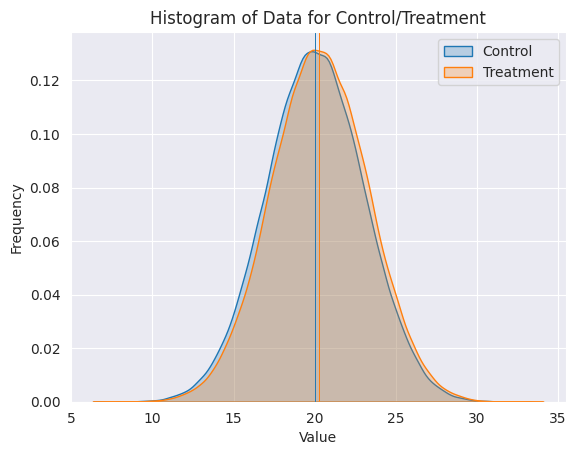

In [84]:
# Histogram of sampled data
sns.kdeplot(data_C, color = _colors[0], label = "Control", fill = True)
sns.kdeplot(data_T, color = _colors[1], label = "Treatment", fill = True)
plt.axvline(x = true_mean_C, color = _colors[0], linewidth = 0.7, linestyle = "-")
plt.axvline(x = true_mean_T, color = _colors[1], linewidth = 0.7, linestyle = "-")
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data for Control/Treatment')
plt.legend()
plt.show()

---
# Part 2: Specify Priors

Assume Conjugate normal priors with distinct means and variances

In [85]:
# Control
delta_h0 = 0
sigma_h0 = 2

# Treatment
delta_h1 = 1
sigma_h1 = 2

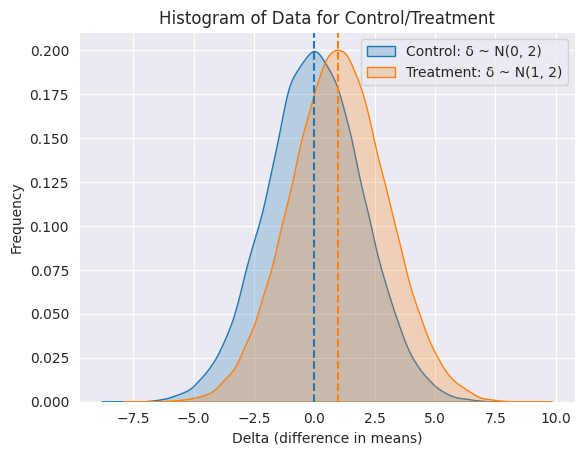

In [86]:
# Sample from prior distribution
prior_samples_control = np.random.normal(delta_h0, sigma_h0, 100000)
prior_samples_treatment = np.random.normal(delta_h1, sigma_h1, 100000)

# Histogram of sampled data
sns.kdeplot(prior_samples_control, fill = True, label = f'Control: δ ~ N({delta_h0}, {sigma_h0})')
sns.kdeplot(prior_samples_treatment, fill = True, label = f'Treatment: δ ~ N({delta_h1}, {sigma_h1})')
plt.axvline(x = delta_h0, color = _colors[0], linestyle = "--")
plt.axvline(x = delta_h1, color = _colors[1], linestyle = "--")
plt.xlabel('Delta (difference in means)')
plt.ylabel('Frequency')
plt.title('Histogram of Data for Control/Treatment')
plt.legend()
plt.show()

---
# Part 3: Bayes factor

Marginal likelihood ratio with the following hypotheses:

$$ \mathbf{H_0}: \delta \leq 0 \qquad\quad \mathbf{H_1}: \delta > 0 $$


Following an implementation of Deng et Al (2016), in Wan et al (2023), the following bayes factor calculation is used:

$\mu'$ is calculated as $\frac{y\sigma_i^2 + \mu_i\sigma^2}{\sigma_i^2 + \sigma^2}$
and $\sigma_i'$ as $\sqrt{\frac{1}{\sigma^2 + \sigma_i^2}}$ for $i \in \{0, 1\}$.



The exact Bayes Factor for one-sided test is:

$$
\text{BF}[H_1 : H_0] = \frac{P(y|H_1)}{P(y|H_0)}
= \frac{ \int_{\mu>0} p(y|\mu)p(\mu|H_1)d\mu}{ \int_{\mu<0} p(y|\mu)p(\mu|H_0)d\mu}
$$

$$
= \frac{1 - \Phi(-\mu_1'/\sigma_1')}{1 - \Phi(-\mu_1/\sigma_1)} \times \frac{\Phi(-\mu_0/\sigma_0)}{\Phi(-\mu_0'/\sigma_0')} \times \sqrt{\frac{\sigma_0^2 + \sigma^2}{\sigma_1^2 + \sigma^2}} \times \exp\left(\frac{-1}{2}\left(\frac{(\mu_1 - y)^2}{\sigma^2 + \sigma_1^2}\right) + \frac{1}{2}\left(\frac{(\mu_0 - y)^2}{\sigma^2 + \sigma_0^2}\right)\right)
$$

With

$$
P(y|H_0) = \int_{\mu<0} p(y|\mu)p(\mu|H_0)d\mu =
\frac{1}{\sqrt{2\pi(\sigma_0^2 + \sigma^2)}} \exp \left( - \frac{1}{2} \frac{(\mu_0 - y)^2}{\sigma^2 + \sigma_0^2} \right) \frac{\Phi(-\mu_0'/\sigma_0')}{\Phi(-\mu_0/\sigma_0)}
$$

and

$$
P(y|H_1) = \int_{\mu>0} p(y|\mu)p(\mu|H_1)d\mu =
\frac{1}{\sqrt{2\pi(\sigma_1^2 + \sigma^2)}} \exp \left( - \frac{1}{2} \frac{(\mu_1 - y)^2}{\sigma^2 + \sigma_1^2} \right) \frac{1 - \Phi(-\mu_1'/\sigma_1')}{1 - \Phi(-\mu_1/\sigma_1)}
$$



In [87]:
def phi(x):
    """Cumulative distribution function for standard normal distribution."""
    return norm.cdf(x)

In [88]:
def h0(y, sigma, mu_h0, sigma_h0, mu_h0_prime, sigma_h0_prime):
    fraction = phi(-mu_h0_prime / sigma_h0_prime) / phi(-mu_h0 / sigma_h0)
    exp_term = np.exp(-0.5 * ((mu_h0 - y)**2 / (sigma**2 + sigma_h0**2)))
    scalar = 1 / np.sqrt(2 * np.pi * (sigma**2 + sigma_h1**2))

    marginal_likelihood = scalar * exp_term * fraction

    return marginal_likelihood

In [89]:
def h1(y, sigma, mu_h1, sigma_h1, mu_h1_prime, sigma_h1_prime):
    fraction = (1 - phi(-mu_h1_prime / sigma_h1_prime)) / (1 - phi(-mu_h1 / sigma_h1))
    exp_term = np.exp(-0.5 * ((mu_h1 - y)**2 / (sigma**2 + sigma_h1**2)))
    scalar = 1 / np.sqrt(2 * np.pi * (sigma**2 + sigma_h1**2))

    marginal_likelihood = scalar * exp_term * fraction

    return marginal_likelihood

In [90]:
def update_mean(y, mu, sigma, sigma_prior):
    """Compute the updated mean after observing the data."""
    return (y * sigma_prior**2 + mu * sigma**2) / (sigma_prior**2 + sigma**2)

def update_sd(sigma, sigma_prior):
    """Compute the updated standard deviation after observing the data."""
    return np.sqrt(1 / (1/sigma**2 + 1/sigma_prior**2))

In [91]:
def bayes_factor(y, mu_h0, sigma_h0, mu_h1, sigma_h1, sigma, n):
    """Compute the Bayes Factor given the data and hypotheses."""

    mu_h0_prime = update_mean(y, mu_h0, sigma, sigma_h0)
    mu_h1_prime = update_mean(y, mu_h1, sigma, sigma_h1)
    sigma_h0_prime = update_sd(sigma, sigma_h0)
    sigma_h1_prime = update_sd(sigma, sigma_h1)

    p_y_h0 = h0(y, sigma, mu_h0, sigma_h0, mu_h0_prime, sigma_h0_prime)
    p_y_h1 = h1(y, sigma, mu_h1, sigma_h1, mu_h1_prime, sigma_h1_prime)

    BF = (p_y_h1 / p_y_h0)

    return BF

## Early stopping

Settings:
- ```k``` = Bayes factor early stopping criteria
- ```interim_test_interval``` = stepsize for sequential tests
- ```enable_es``` = continue/stop after triggering stopping criteria
- ```minimum_sample``` = minimum sample size (accounting for potential volatility in small samples)

In [92]:
# Settings
k = 30
interim_test_interval = 1
enable_es = True
minimum_sample = 500

In [93]:
# Initialise
bf, n_observed = 0, minimum_sample

 # first n_observed is kind of cold start n (n_observed >= 2)
interim_tests = []

while n_observed <= N:
    # Get delta & sigma (given n_observed)
    delta_n = data_T[:n_observed].mean() - data_C[:n_observed].mean()
    sigma_n = data_C[:n_observed].var()/n_observed + data_T[:n_observed].var()/n_observed
    sigma_n = np.sqrt(sigma_n)

    # Get & store (beta) Bayes Factor
    bf = bayes_factor(delta_n, delta_h0, sigma_h0, delta_h1, sigma_h1, sigma_n, n_observed)
    interim_tests.append((n_observed, bf))

    # Extend sample & get conversions
    n_observed += interim_test_interval

    # Stopping criteria
    if enable_es == True and (bf > k or bf < 1/k):
        break

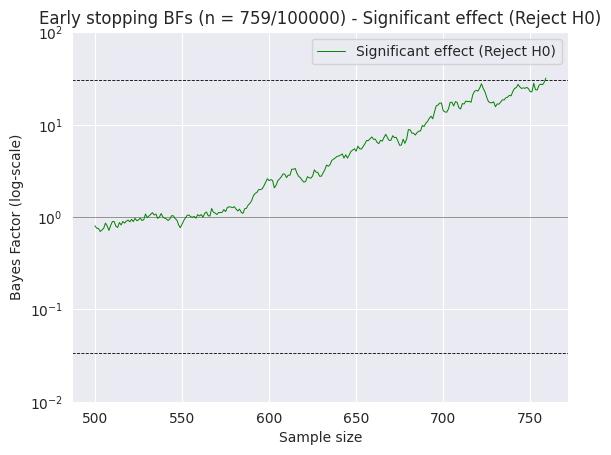

In [94]:
def plot_early_stopping(interim_tests):
    # plot stopping criteria
    plt.axhline(y = 1, color = "grey", linewidth = "0.6")
    plt.axhline(y = k, color = "black", linestyle = "--", linewidth = "0.6")
    plt.axhline(y = 1/k, color = "black", linestyle = "--", linewidth = "0.6")

    # Plot interim testing Bayes-Factor development
    if interim_tests[-1][1] > 1: # Reject H0 (Effect discovery)
        color_i = "green"
        conclusion = "Significant effect (Reject H0)"
    else: # Accept H0 (No effect)
        color_i = "red"
        conclusion = "No effect (Accept H0)"

    x, y = zip(*interim_tests)
    plt.plot(x, y, linestyle = "-", linewidth = 0.7, color = color_i, label = conclusion)

    # Set the y-axis to log scale
    plt.yscale('log')
    plt.xlabel("Sample size")
    plt.ylabel("Bayes Factor (log-scale)")
    plt.legend()
    plt.title(f"Early stopping BFs (n = {interim_tests[-1][0]}/{N}) - {conclusion}")
    plt.ylim(0.01, 100)
    plt.show()

plot_early_stopping(interim_tests)

In [95]:
# Print experiment details
print(f"Priors: \nH0: delta = {delta_h0}, sigma = {sigma_h0} \nH1: delta = {delta_h1}, sigma = {sigma_h1}")
print(f"\nData full: \nC: mean = {true_mean_C}, sigma = {true_sigma_C}, N = {N} \nT: mean = {true_mean_T}, sigma = {true_sigma_T}, N = {N} \ndelta = {delta:.3f}, sigma = {sigma:.3f}")

delta_n = data_T[:n_observed].mean() - data_C[:n_observed].mean()
sigma_n = data_C[:n_observed].var()/n_observed + data_T[:n_observed].var()/n_observed

if n_observed < N:
  print(f"\nData observed (Early stopped): \nC: mean = {data_C[:n_observed].mean():.3f}, sigma = {data_C[:n_observed].var():.3f}, N = {n_observed} \nT: mean = {data_T[:n_observed].mean():.3f}, sigma = {data_T[:n_observed].var():.3f}, N = {n_observed} \ndelta = {delta_n:.3f}, sigma = {sigma_n:.3f}\n")

Priors: 
H0: delta = 0, sigma = 2 
H1: delta = 1, sigma = 2

Data full: 
C: mean = 20, sigma = 3, N = 100000 
T: mean = 20.3, sigma = 3, N = 100000 
delta = 0.284, sigma = 0.000

Data observed (Early stopped): 
C: mean = 19.991, sigma = 8.522, N = 760 
T: mean = 20.297, sigma = 8.742, N = 760 
delta = 0.305, sigma = 0.023



In [96]:
interim_tests

[(500, 0.8002423863896256),
 (501, 0.7537306960175265),
 (502, 0.7498852960506982),
 (503, 0.6960901152467116),
 (504, 0.7222049152775202),
 (505, 0.75447588887312),
 (506, 0.8566147867059553),
 (507, 0.79641045357174),
 (508, 0.7154358701048662),
 (509, 0.8081819356093827),
 (510, 0.8921699437605648),
 (511, 0.8912519365195958),
 (512, 0.7924108124844765),
 (513, 0.7680448696416975),
 (514, 0.8691246562714554),
 (515, 0.8189217884268816),
 (516, 0.8935601630123763),
 (517, 0.8570120612624471),
 (518, 0.9006828578218095),
 (519, 0.9232718464673313),
 (520, 0.8849413104688025),
 (521, 0.9409797755378292),
 (522, 0.8908476133244959),
 (523, 0.9668014484154719),
 (524, 0.9108926611380953),
 (525, 0.9272704430012513),
 (526, 0.9723077168458244),
 (527, 0.9138815776019149),
 (528, 0.93352243923044),
 (529, 1.076151067113114),
 (530, 0.9796522778316498),
 (531, 1.023145381071846),
 (532, 1.069986926282778),
 (533, 1.1131255797848123),
 (534, 1.0486833611492243),
 (535, 1.0743110688172641),
 